In [22]:
%load_ext autoreload
%autoreload 2
from methods2final import * 
sc.settings.verbosity = 3  
sc.settings.set_figure_params(dpi=160)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
adata = sc.read_h5ad("write/pfc2018.h5ad")
adata

AnnData object with n_obs × n_vars = 2378 × 4490 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'ID', 'week'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene'
    uns: 'pca', 'week_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:26.59) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


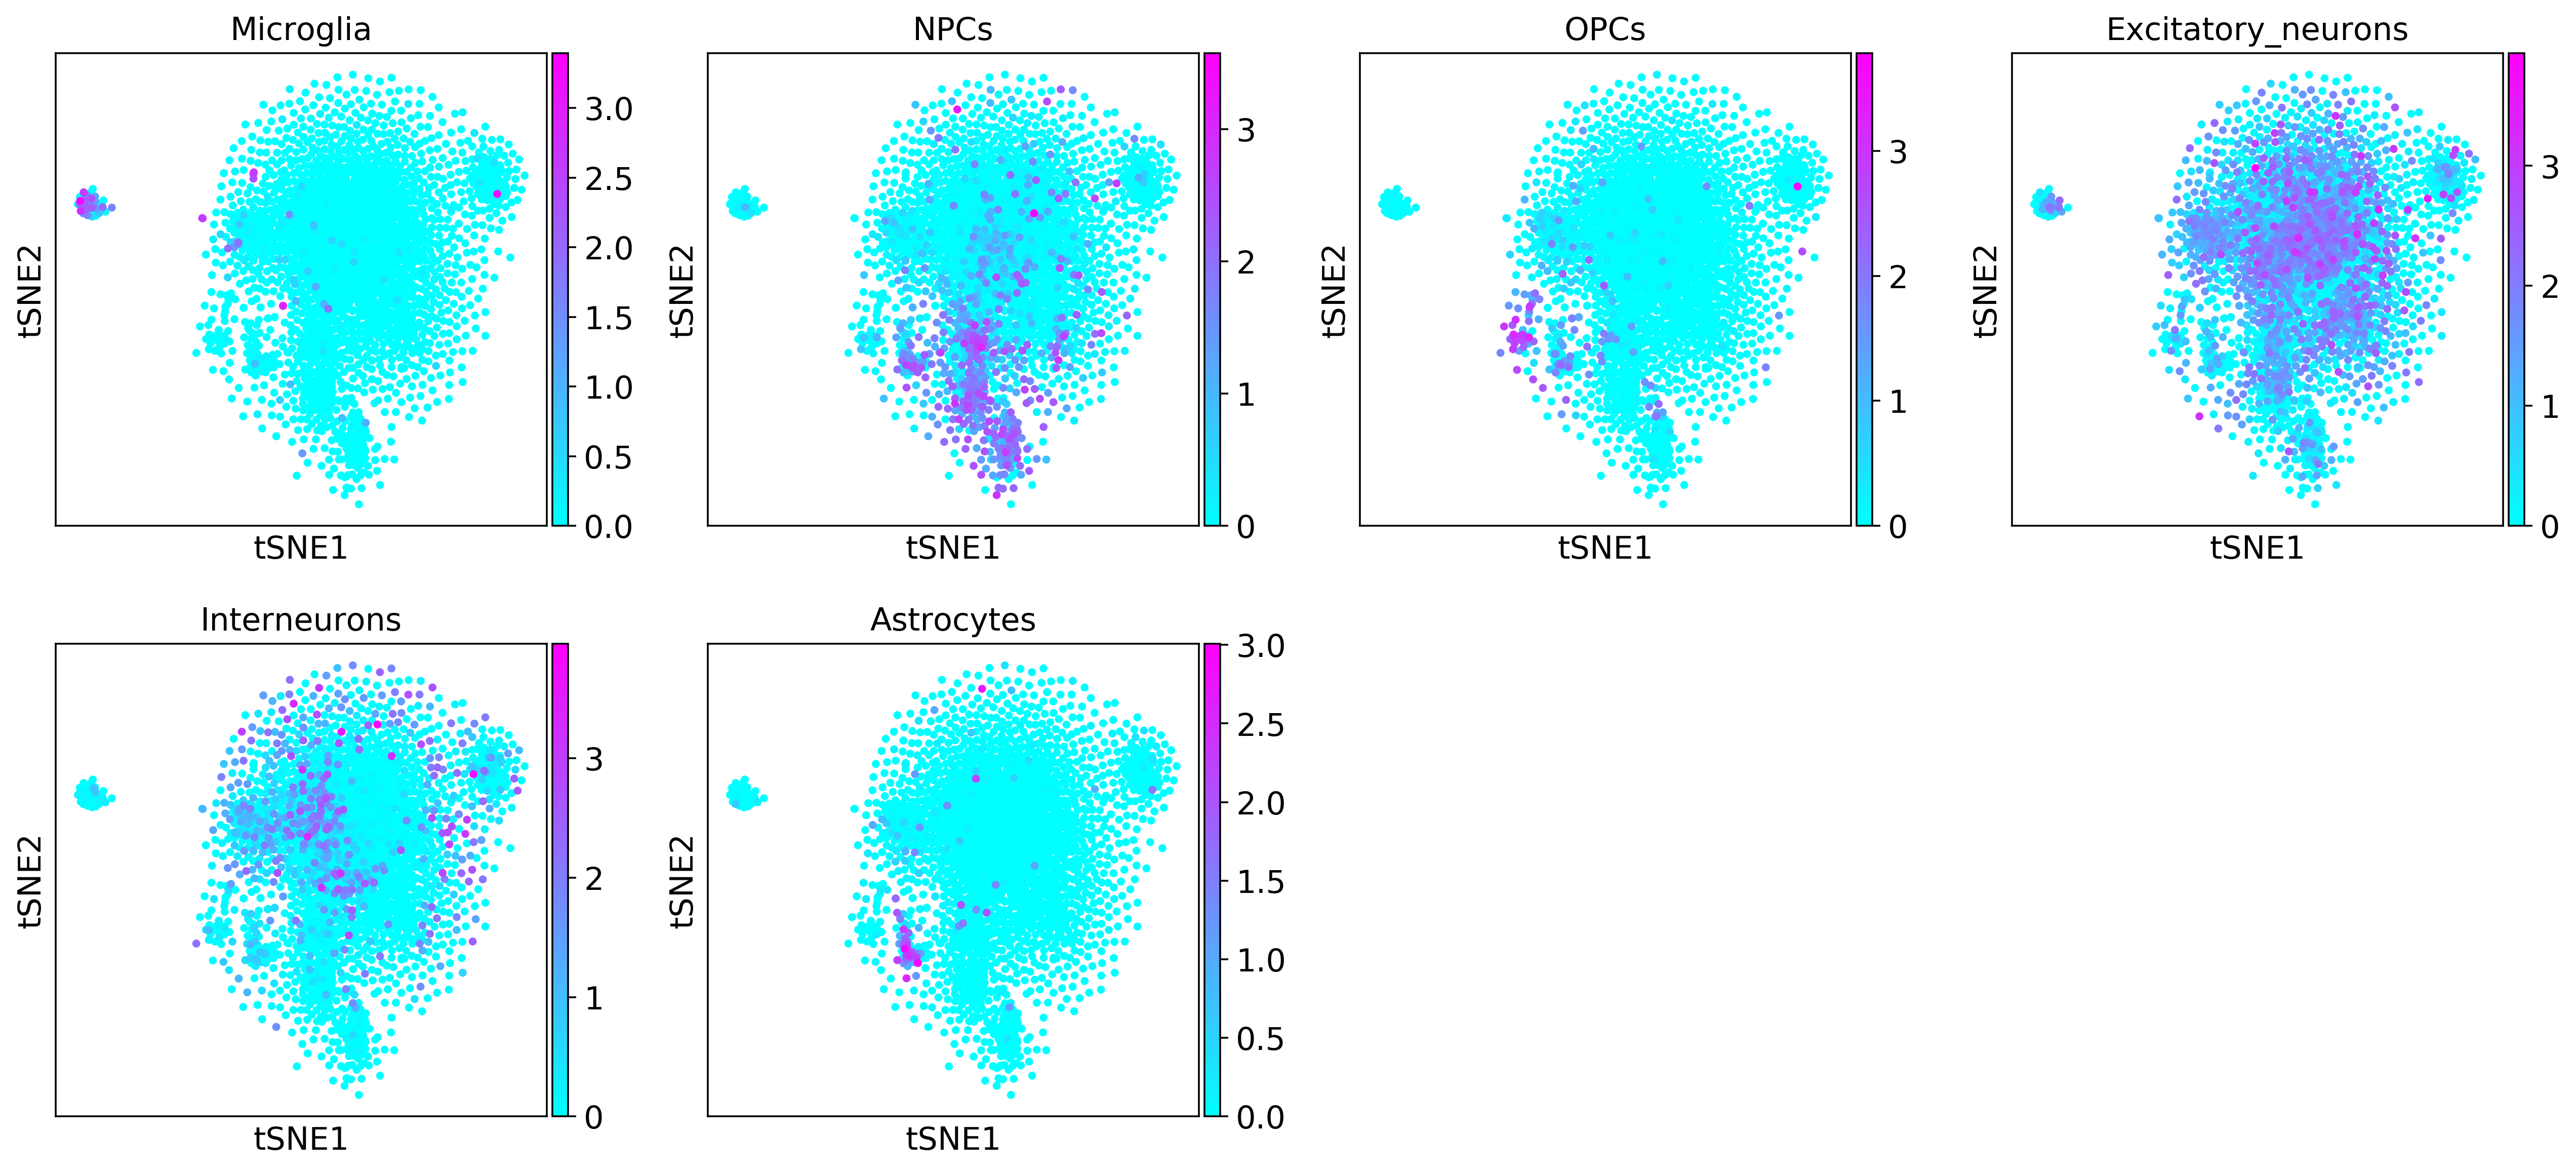

In [71]:
sc.tl.tsne(adata, use_rep='X')
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [4]:
batch_size = 256
dataset = torch.tensor(adata.X)
tensor_max_value = torch.max(dataset)
dataset = dataset/tensor_max_value
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [134]:
adata.X = dataset.detach().numpy()

In [135]:
sc.tl.tsne(adata, use_rep='X')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:27.18) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


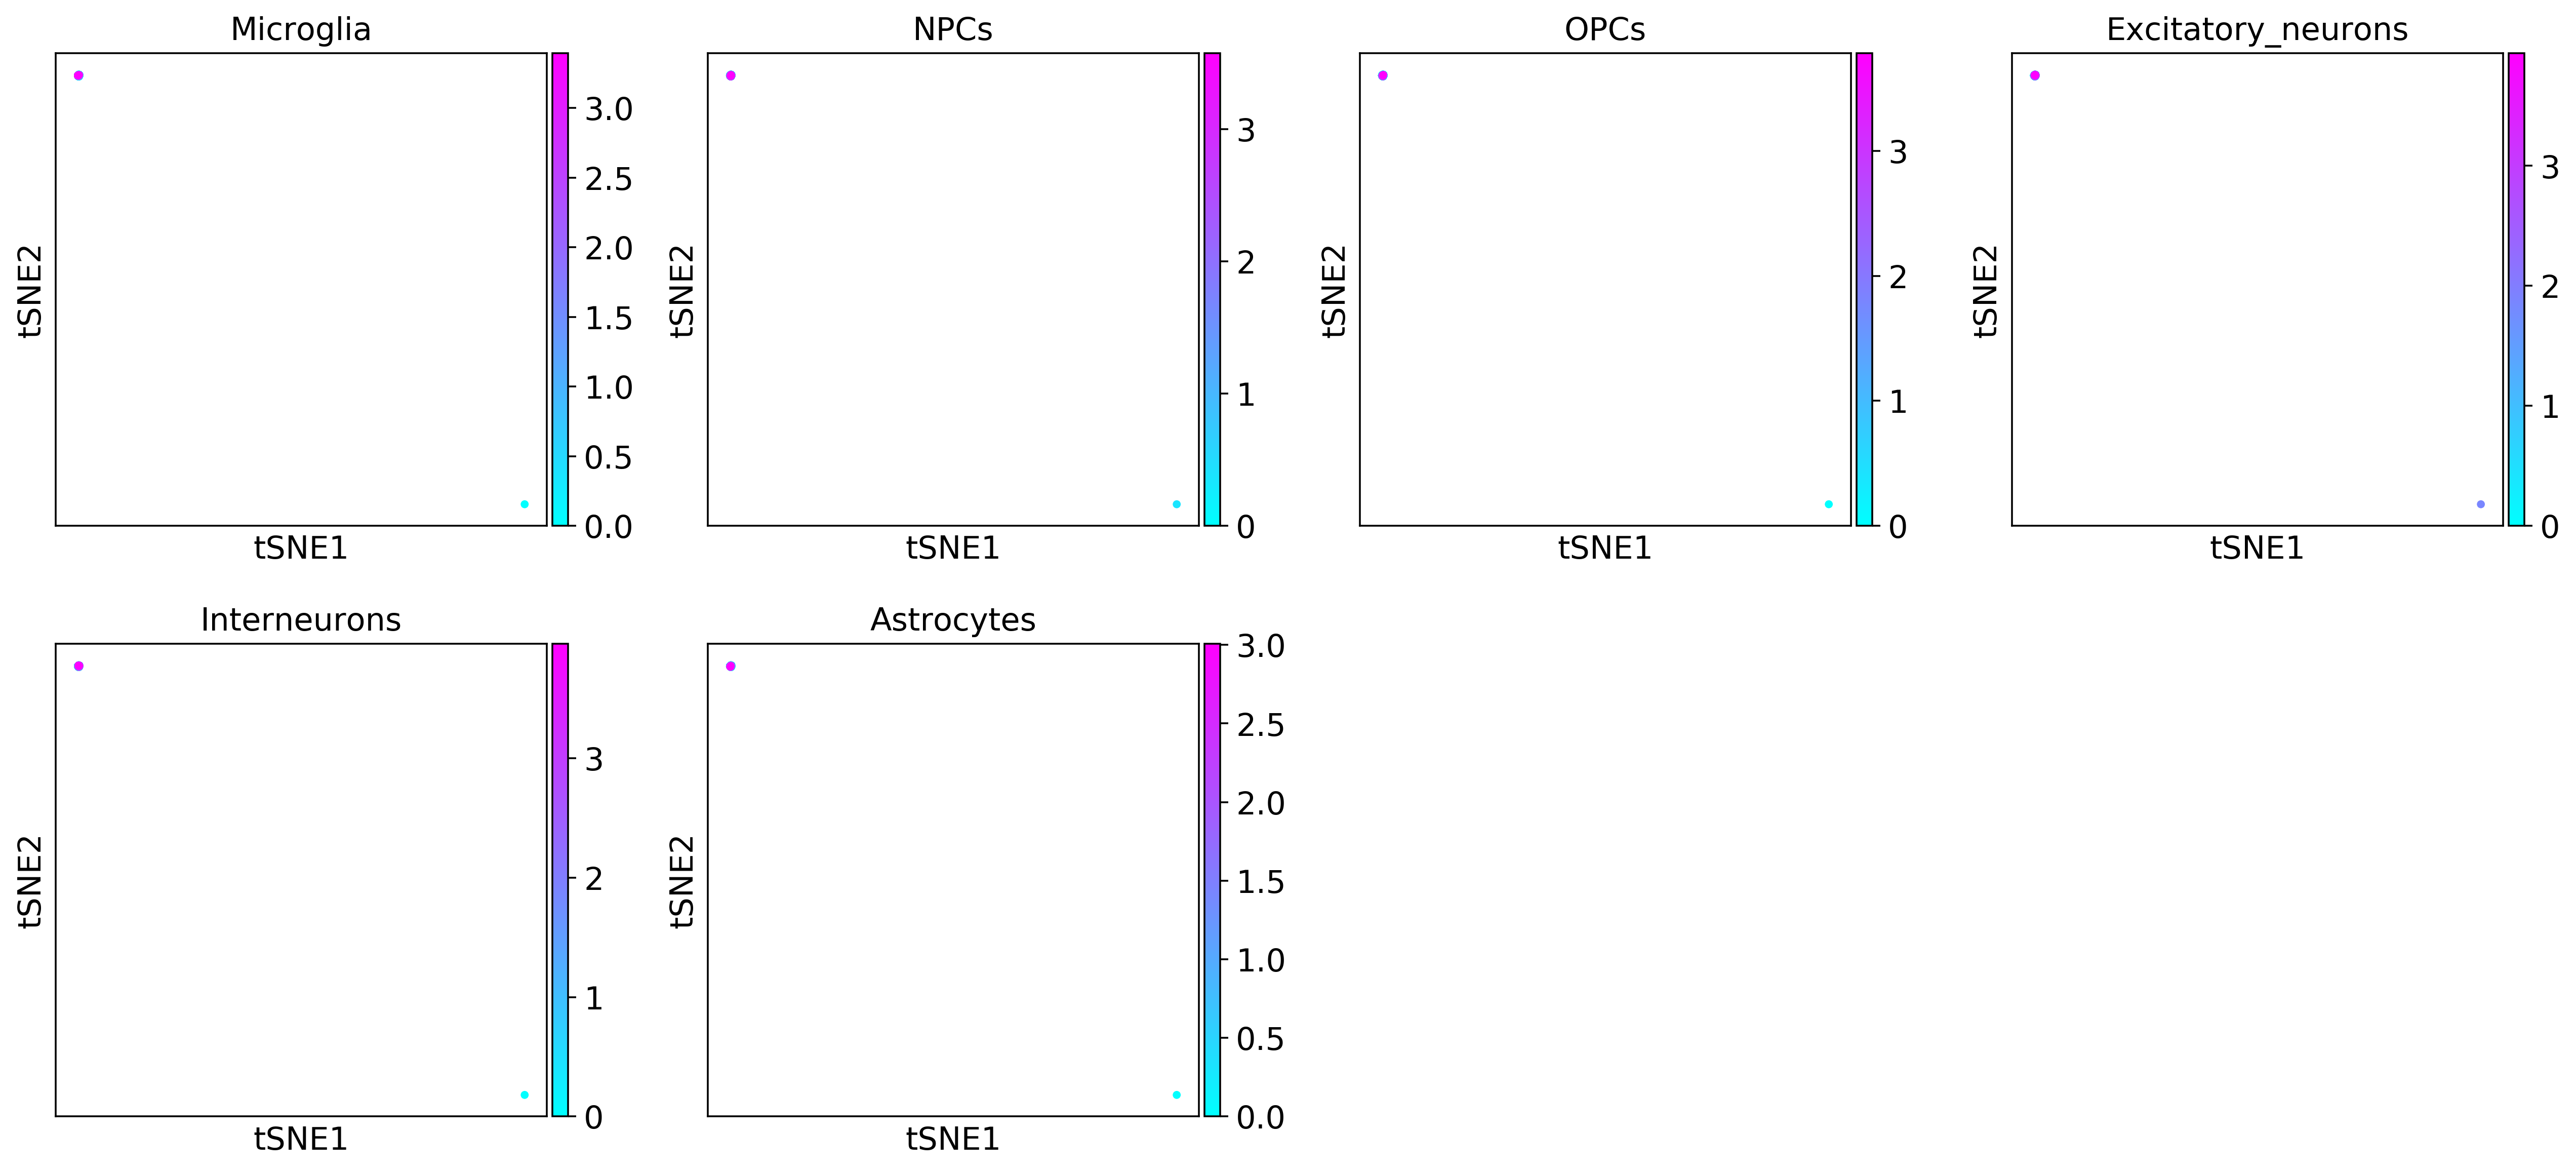

In [136]:
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

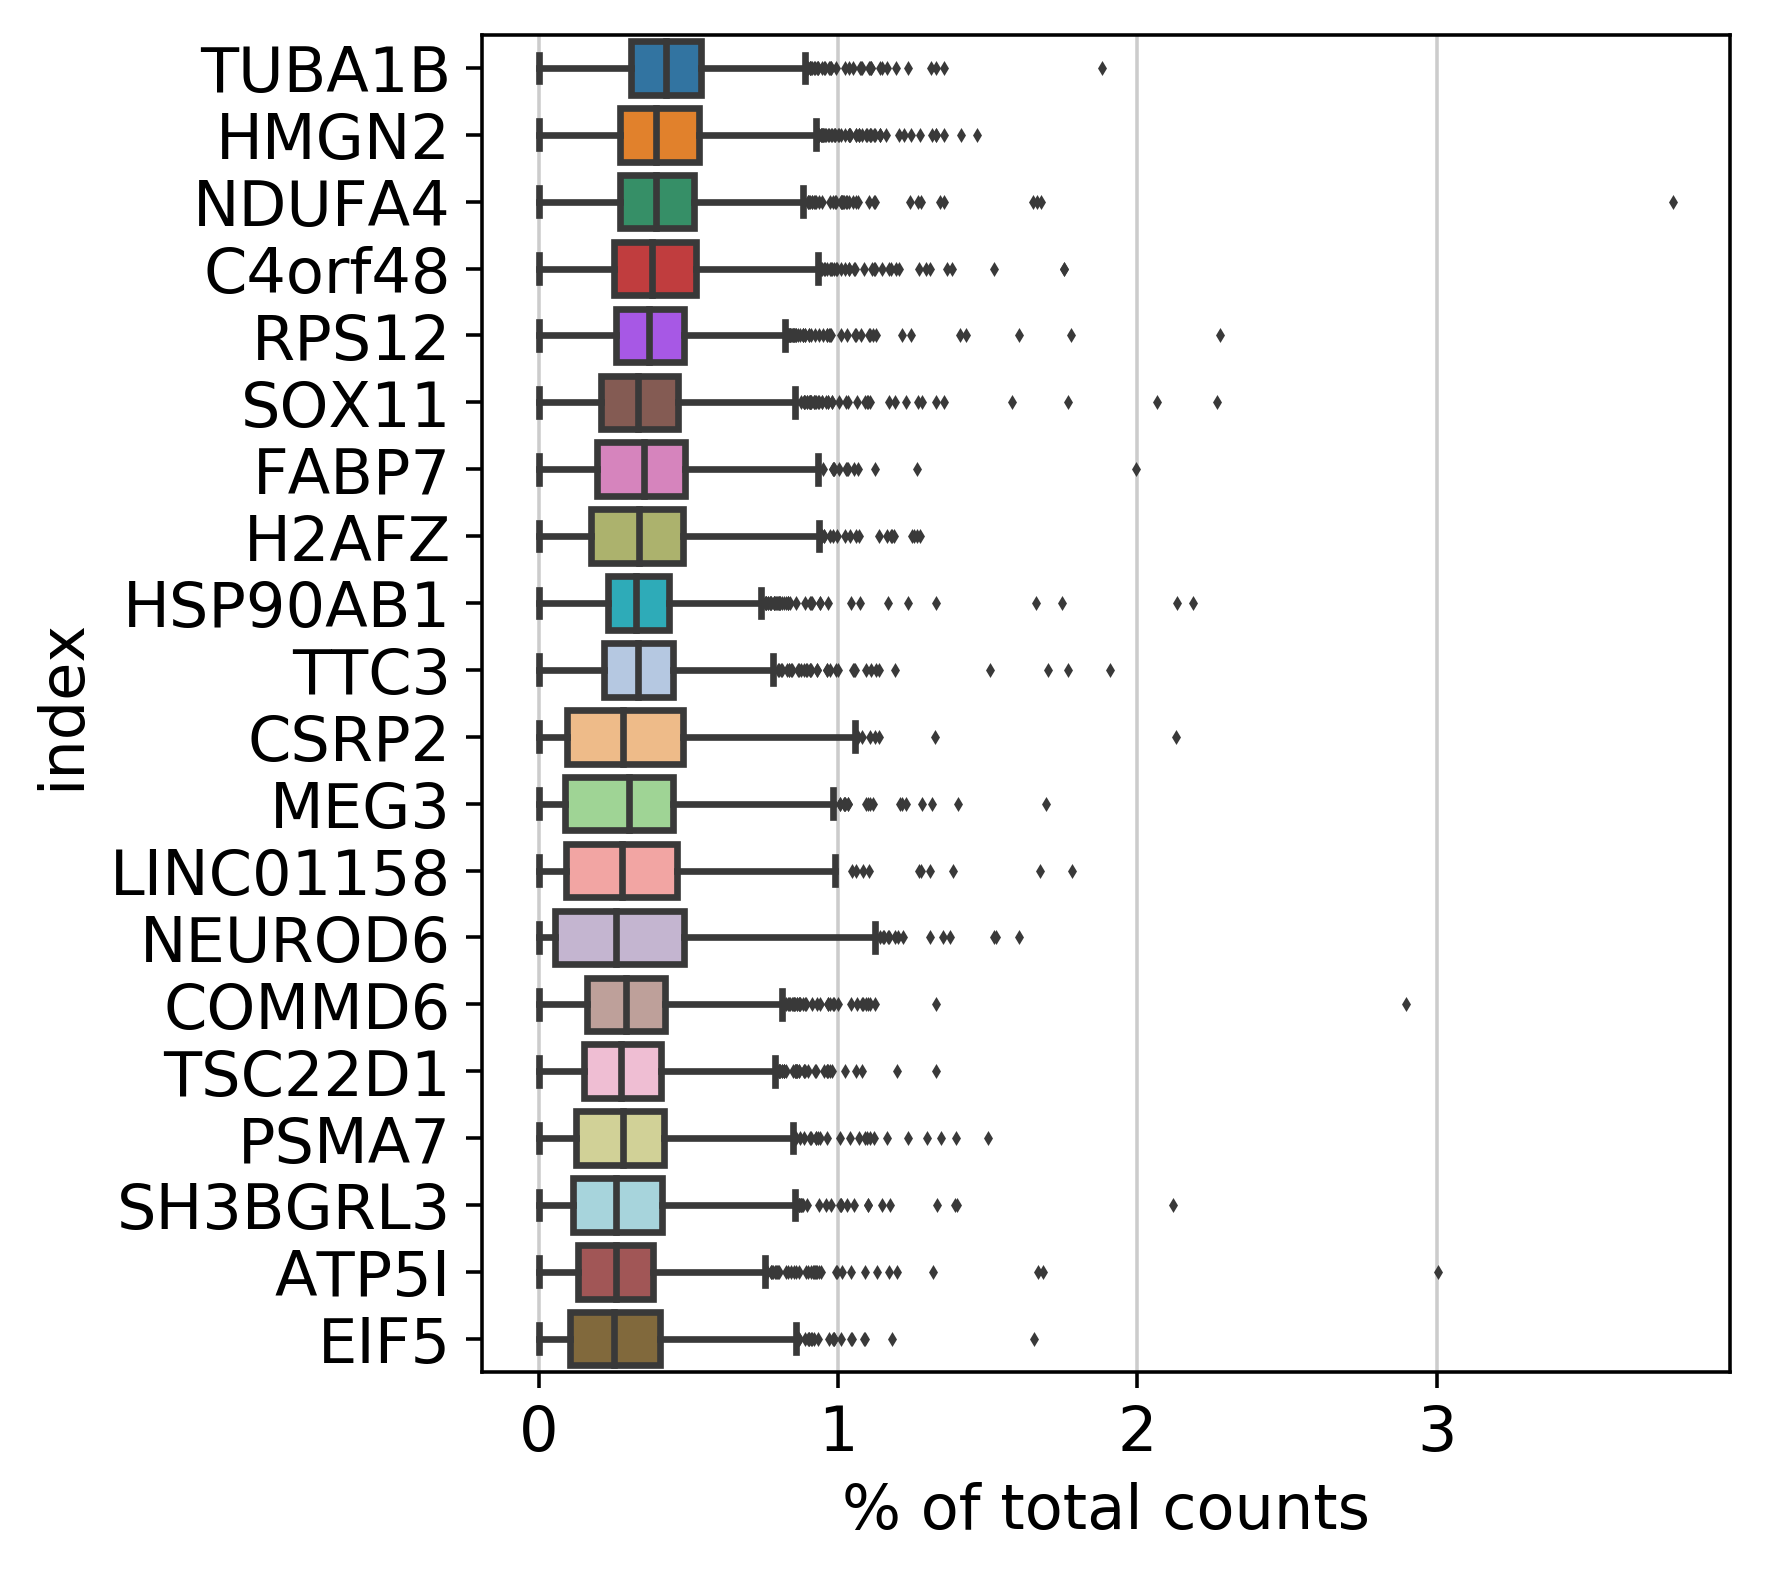

In [137]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [5]:
vae = VAE(image_size=4490)
if torch.cuda.is_available():
    print("Model on GPU")
    vae.cuda()
vae

Model on GPU


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=4490, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=40, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=4490, bias=True)
    (3): Sigmoid()
  )
)

In [8]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train(data_loader, vae, optimizer, batch_size, epochs=500)

Epoch[1/500] Loss: 86.143
Epoch[51/500] Loss: 82.182
Epoch[101/500] Loss: 82.880
Epoch[151/500] Loss: 84.508
Epoch[201/500] Loss: 83.926
Epoch[251/500] Loss: 85.609
Epoch[301/500] Loss: 80.688
Epoch[351/500] Loss: 82.655
Epoch[401/500] Loss: 84.025
Epoch[451/500] Loss: 90.014


In [9]:
rec_X = vae(to_var(dataset))
print(len(rec_X[0]))
rec_X = rec_X[0].data.cpu()

2378


In [10]:
X = (rec_X*tensor_max_value).detach().numpy()
X.shape

(2378, 4490)

In [11]:
adata.X = X

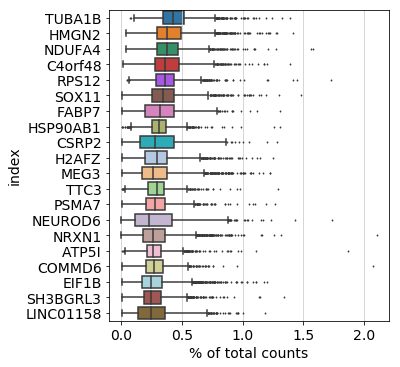

In [12]:
sc.pl.highest_expr_genes(adata, n_top=20)

computing PCA on highly variable genes


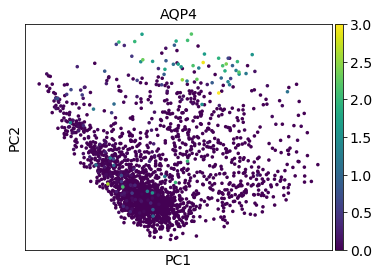

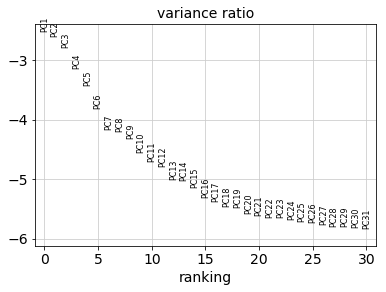

In [13]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='AQP4')
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
sc.tl.tsne(adata, use_rep='X_pca')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:09.62) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


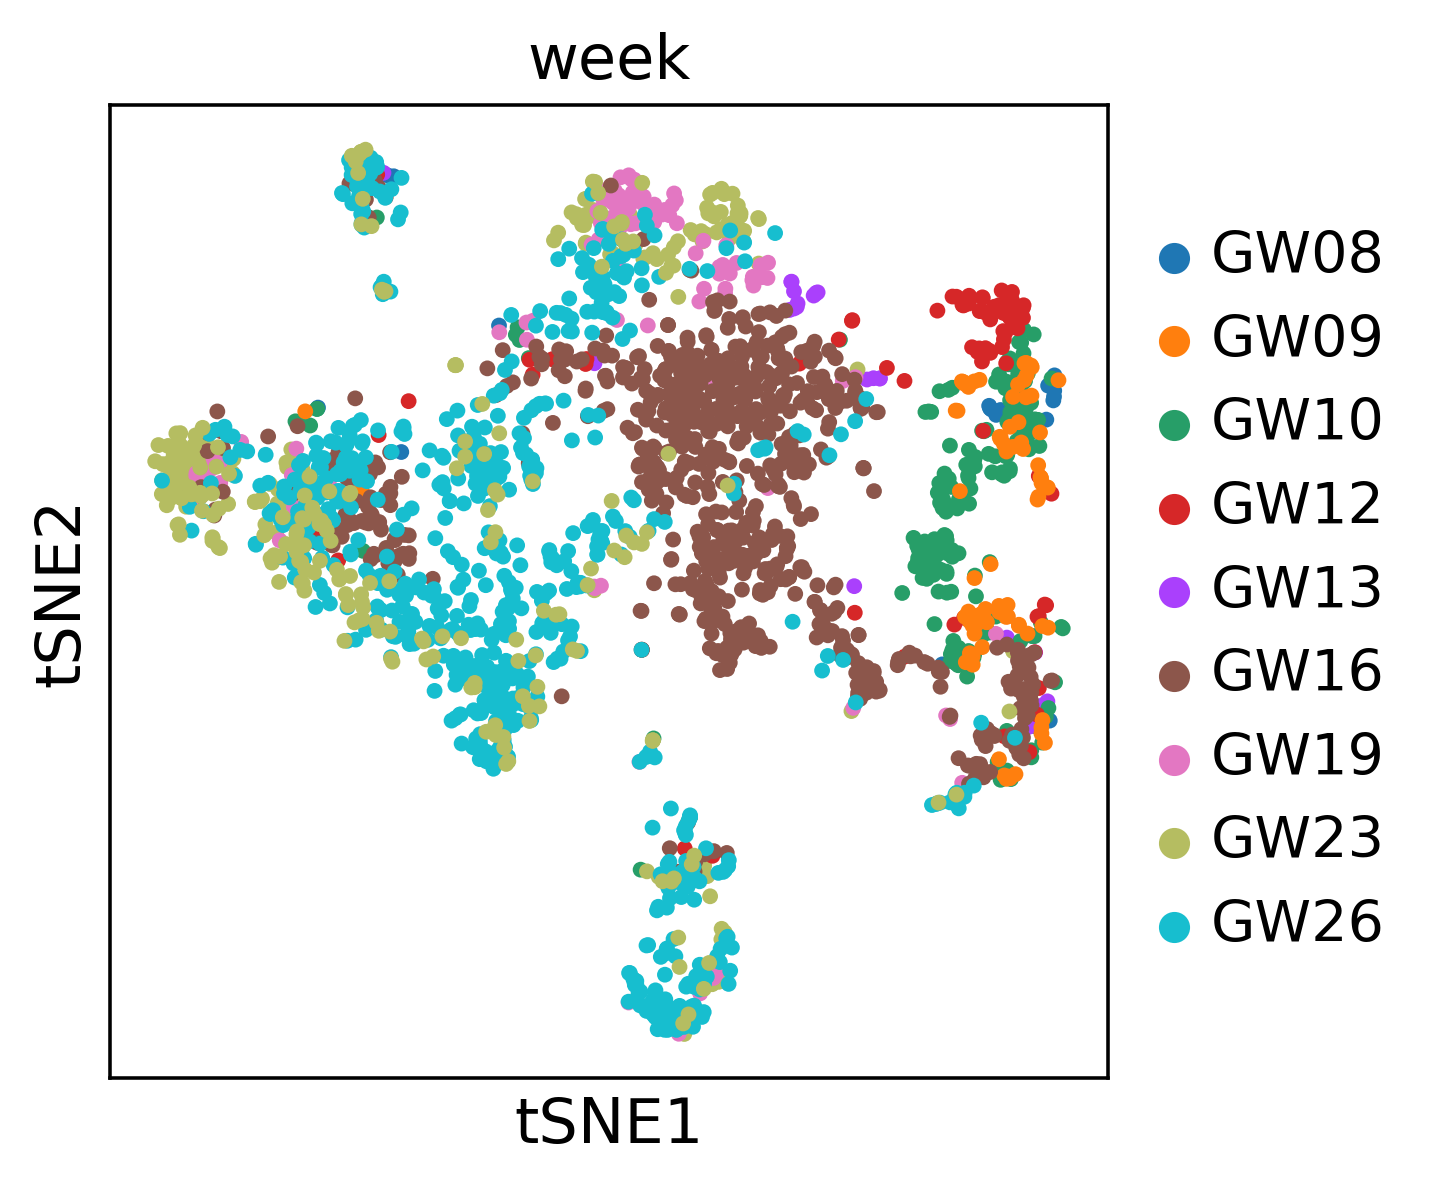

In [27]:
sc.pl.tsne(adata, color='week')

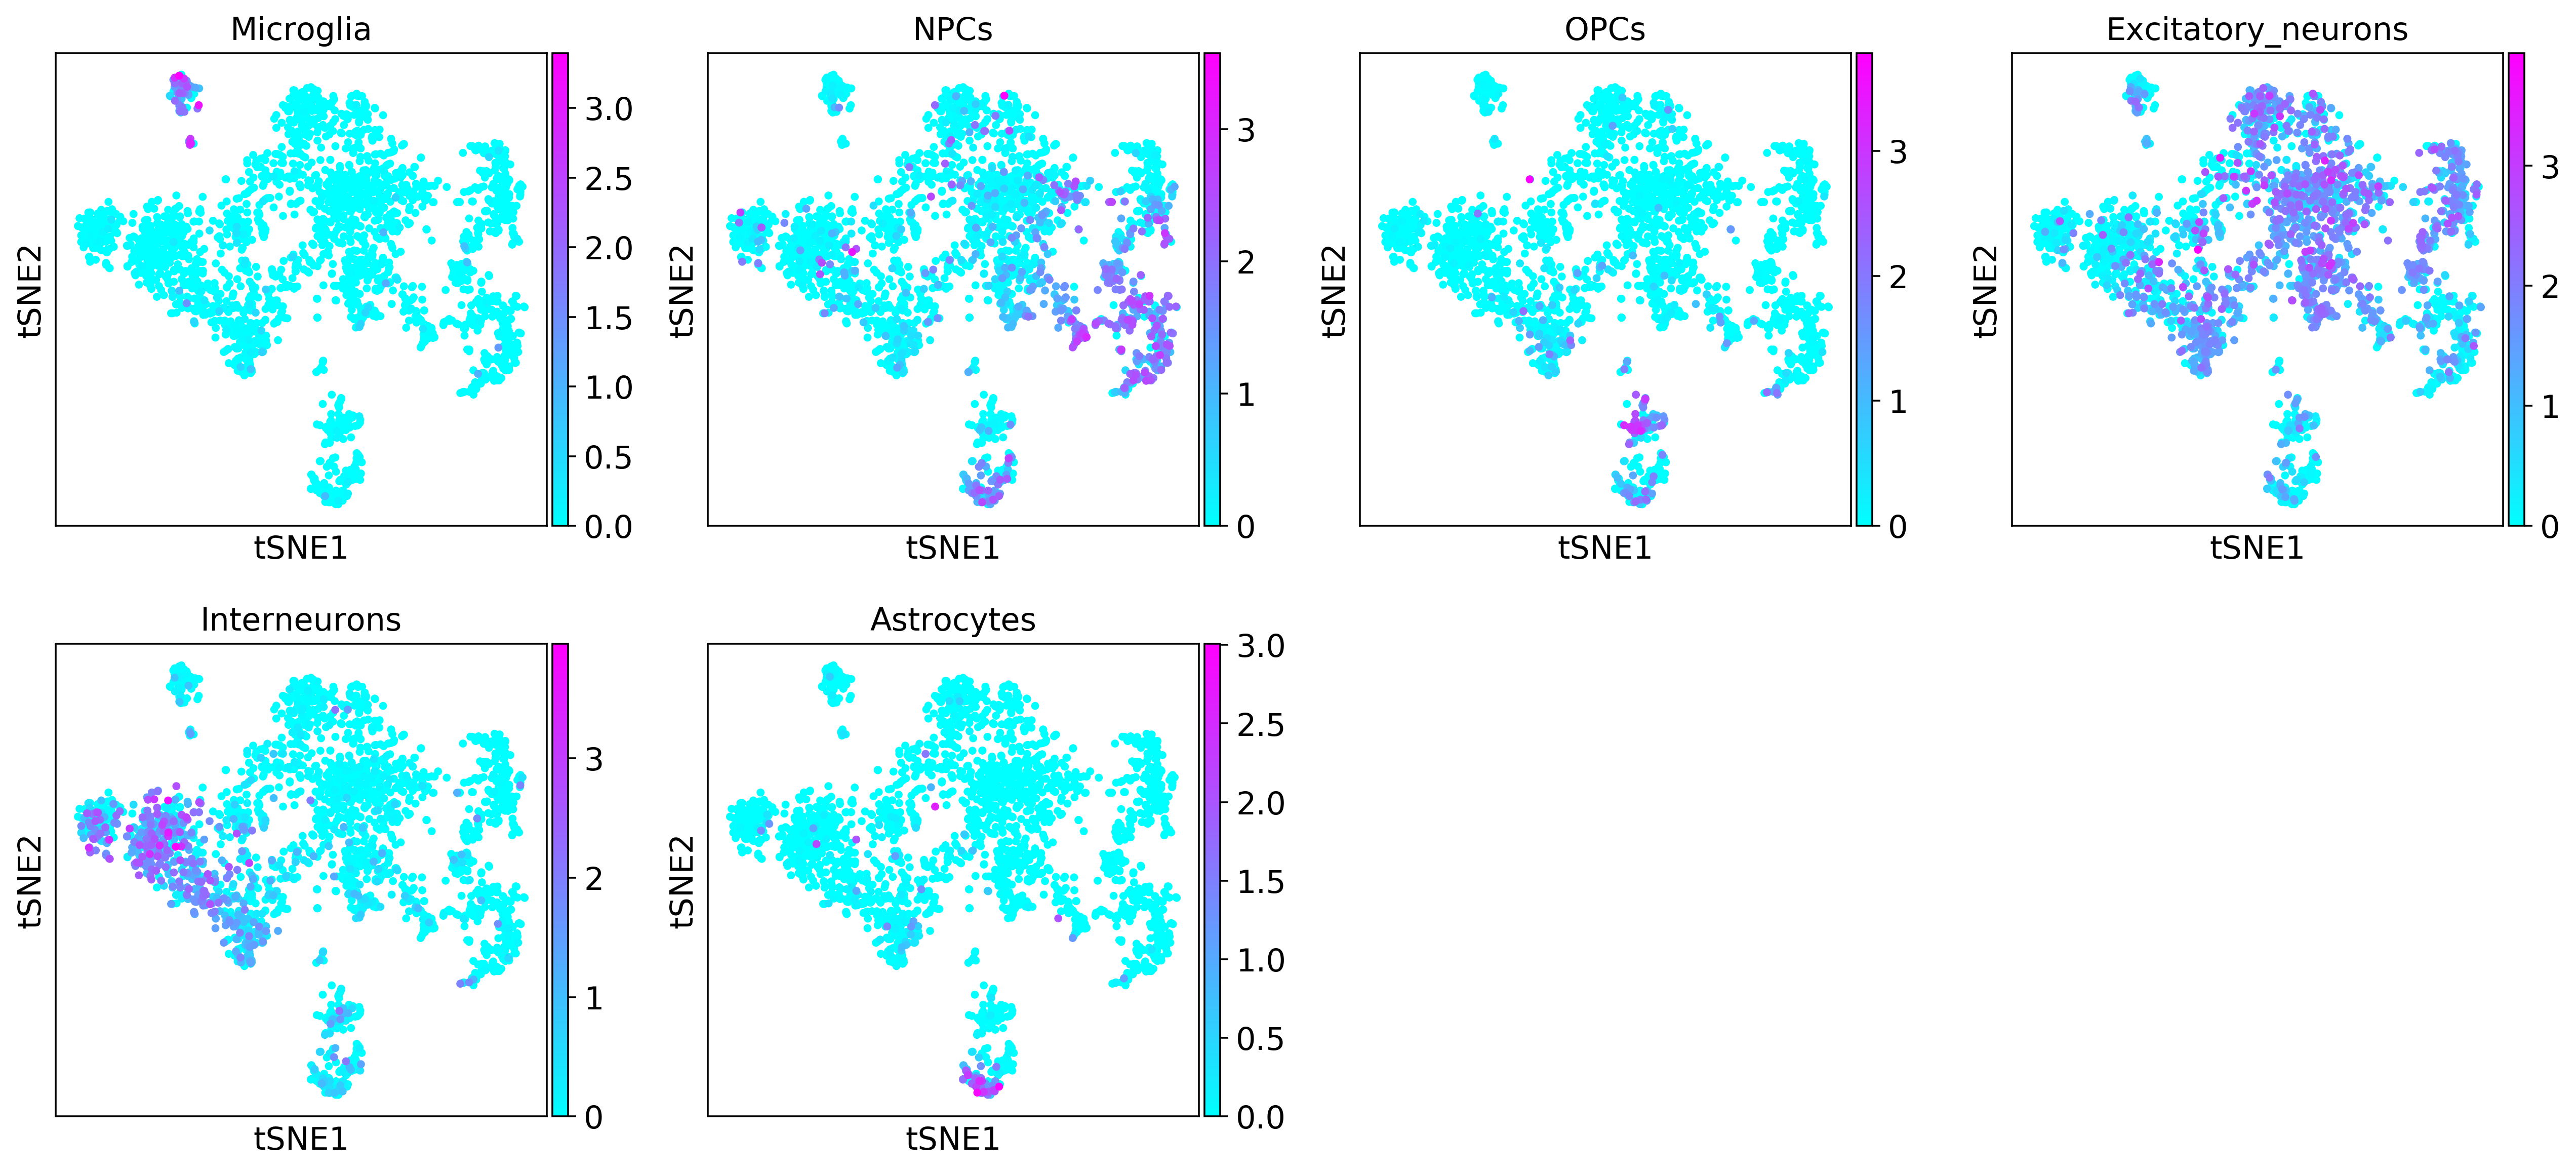

In [28]:
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [29]:
codes = vae.encoder(to_var(dataset))
codes = codes.cpu().detach().numpy()
codes.shape

(2378, 40)

In [30]:
adata.obsm["X_code400"] = codes

In [31]:
sc.tl.tsne(adata, use_rep='X_code400')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:09.96) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


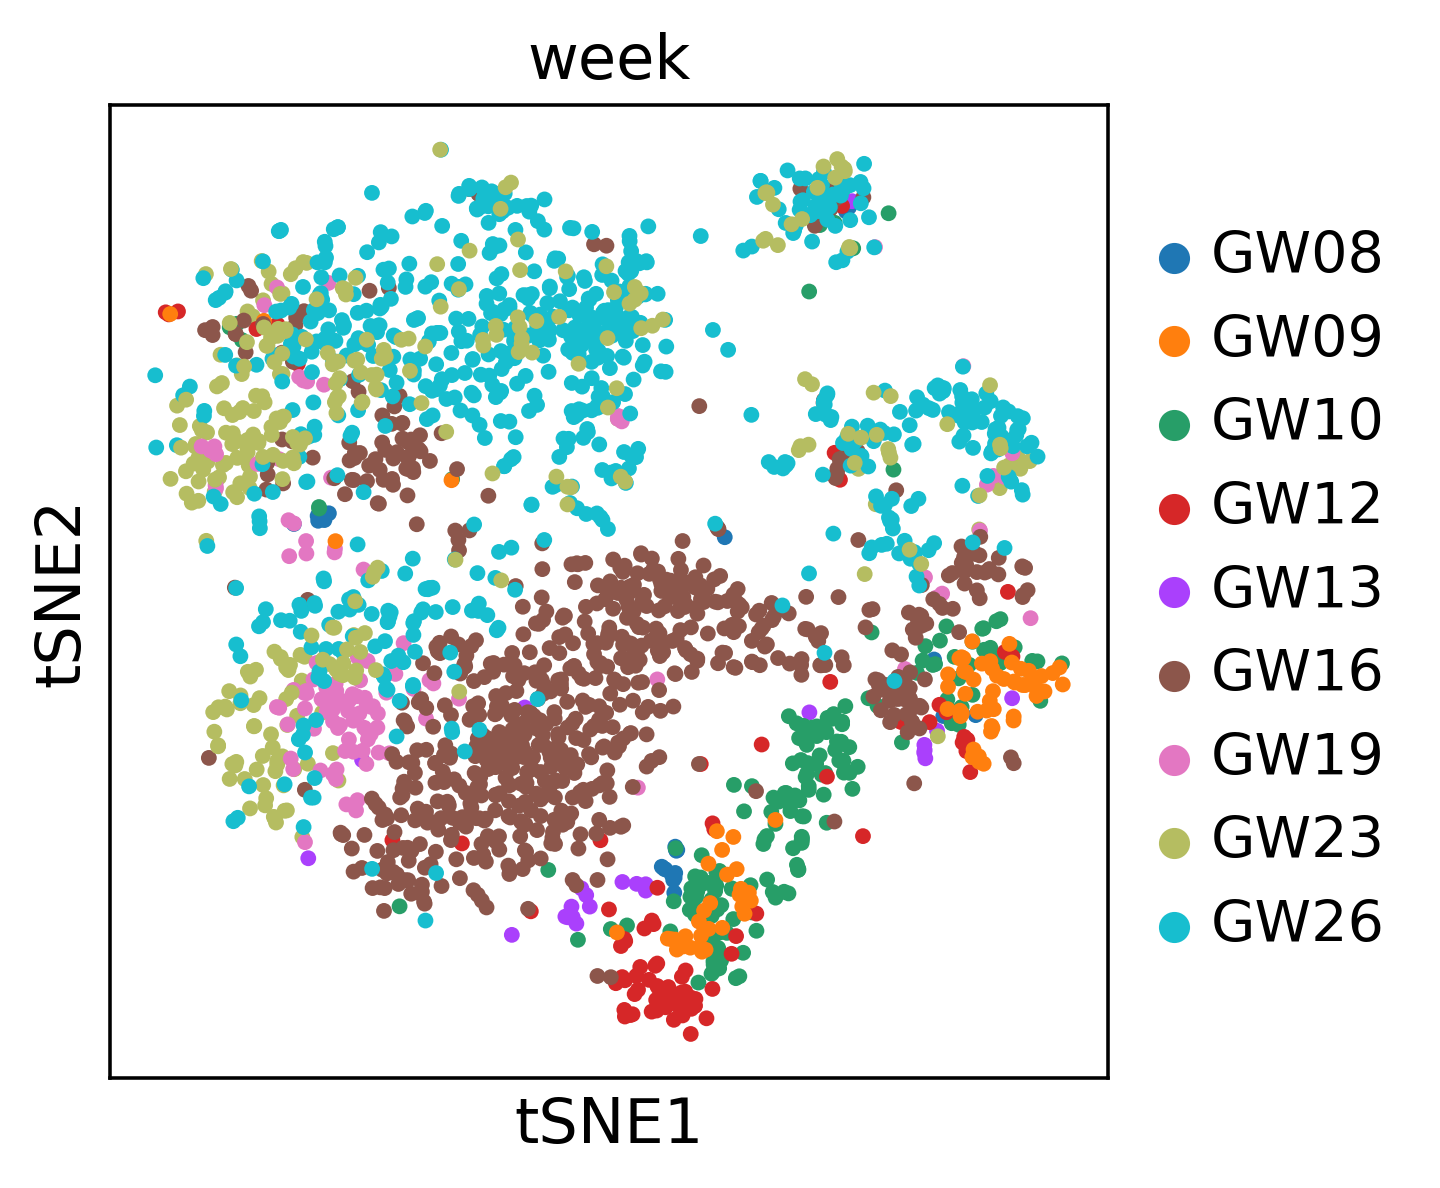

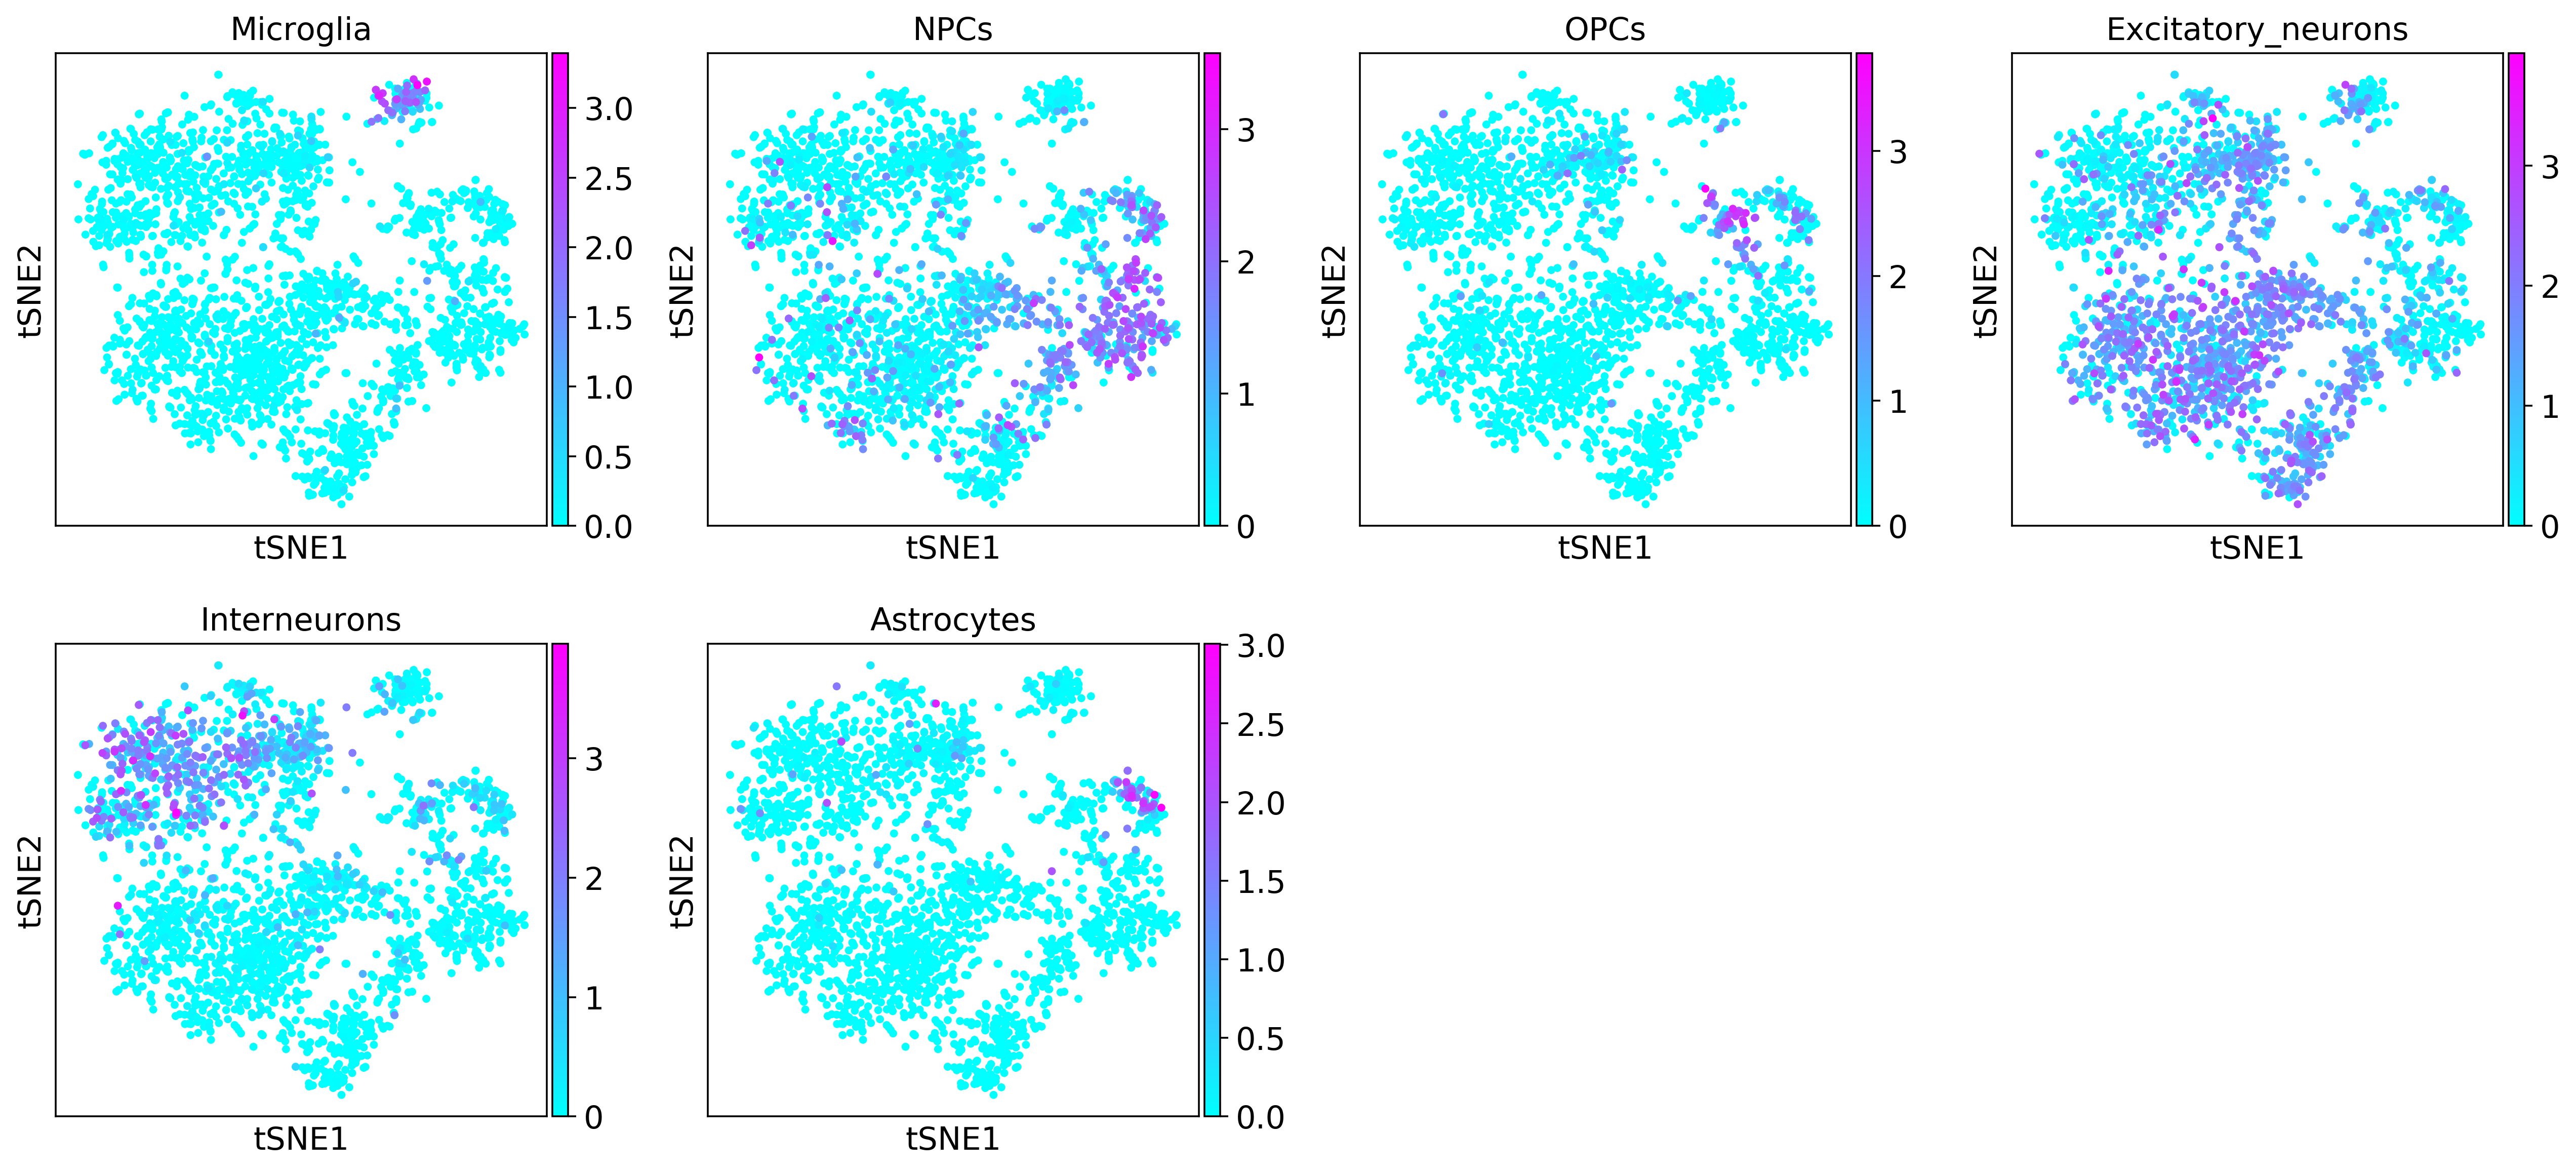

In [32]:
sc.pl.tsne(adata, color='week')
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")